In [1]:
#@title Defining a time-dependent score-based model 
from tqdm.notebook import tqdm
import functools
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pdb
import tqdm
import torch
import functools
import os
import random
import matplotlib.pyplot as plt
import torchvision.transforms as transforms


from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

from torchvision.datasets import FashionMNIST, MNIST
from torchvision import transforms
from torch.utils.data import ConcatDataset
from torch.utils.data import Subset
from torch.utils.data import random_split
from scipy import integrate
from torchvision.utils import make_grid

from PIL import Image

In [2]:
class GaussianFourierProjection(nn.Module): 

    """Gaussian random features for encoding time steps."""
    """
    This class implements Gaussian random features for encoding time steps, often used in Neural ODEs or SDEs for time encoding.
    Gaussian Fourier features are used to map the time t into a higher-dimensional space using sinusoidal functions. 
    This helps the model better capture time dependencies.
    The self.W is a randomly initialized vector of weights used to project t to this higher-dimensional space.
    In forward(), the input x is projected using W, and then both sin and cos functions are applied, 
     concatenating the results into one tensor.
    This class helps encode the time-dependent information, which will be passed into the neural network.
    """
    def __init__(self, embed_dim, scale=30.):
        super().__init__()
        # Randomly sample weights during initialization. These weights are fixed
        # during optimization and are not trainable.
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
    def forward(self, x):
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
    """A fully connected layer that reshapes outputs to feature maps."""
    """
    Dense class implements a fully connected layer that takes input with dimension input_dim and maps it to output_dim.
    The forward pass uses a standard linear transformation (nn.Linear). 
    The output is reshaped with dimensions appropriate for feature maps in convolutional layers 
     (i.e., adding extra dimensions [None, None]).
    This is often used in conjunction with time embeddings or feature mappings to adjust dimensionality.
    """
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.dense = nn.Linear(input_dim, output_dim)
        # print("dimention",input_dim, output_dim)
    def forward(self, x):
        return self.dense(x)[..., None, None]

class ScoreNet(nn.Module):
    """
    A time-dependent score-based model built upon U-Net architecture.
    The U-Net structure is commonly used in generative models and image-to-image tasks, 
    because it allows the model to capture both high- and low-level features through encoding and decoding paths. 
    The key feature of this class is that it predicts the score (gradient of the log probability density) 
    at different time steps in the diffusion process. 
    """
    """
    Time-Dependent Score Estimation: The model estimates the score function S_{\theta}(x,t), 
        which is the gradient of the log-probability distribution \nable_x log p_t(x) at time step t. 
        This score helps the model learn how to denoise samples that have been corrupted by noise over time, 
        allowing it to reverse the diffusion process.
    """
    def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
        """
        Initialize a time-dependent score-based network.
        Args:
            marginal_prob_std: A function that takes time t and gives the standard
                deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
            channels: The number of channels for feature maps of each resolution.
            embed_dim: The dimensionality of Gaussian random feature embeddings.
        """
        """
        The U-Net architecture consists of two main parts:
            Encoder (downsampling): 
                This path reduces the spatial resolution of the input and increases the number of channels. 
                It helps the model capture high-level abstract features.
            Decoder (upsampling): 
                This path increases the spatial resolution and brings back the low-level details 
                by combining features from the encoder through skip connections.
        """
    
        super().__init__()
        # Gaussian random feature embedding layer for time
        """
        Gaussian Fourier Features (GaussianFourierProjection): 
            This is used to map time t into a higher-dimensional space using sinusoidal functions, 
            making it easier for the model to capture complex time dependencies.
        Time Embedding: 
            This time embedding is applied at different points in the network (in the encoding and decoding paths) 
            via the dense layers. The idea is that for different times, the model should behave differently (i.e., 
            it should be able to adjust its predictions based on how much noise has been added to the data).
        """
    
        self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
                                   nn.Linear(embed_dim, embed_dim))
    
        # Encoding layers where the resolution decreases
        """ 
        The encoding part decreases the image resolution while increasing the number of feature maps (channels). 
        This allows the model to capture global patterns in the image.

        Convolutional Layers: conv1, conv2, conv3, conv4 apply 2D convolutions to reduce the resolution and increase channels.
        Dense Embedding for Time: For each layer, a time embedding is added. This is achieved using 
            the dense layers (dense1, dense2, etc.), which take the time embedding and add it to the features.
        Group Normalization: gnorm1, gnorm2, etc. apply group normalization to stabilize the training process.
        """
    
        self.conv1 = nn.Conv2d(3, channels[0], 3, stride=1, padding =1, bias=False) # use nn.Conv2d(3,channels[0], ...) for RGB 
        self.dense1 = Dense(embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
        # output size = 1+ \frac{input size - kernel_size + 2 x Padding}{stride}
        # make sure each layer's output is compactable with the next layer's input, especially if you concat
        # if input_size=128, stide =1, output= 128
        # the output of a conv1 is [batch_size, channels[0], output_width, output_height]
        self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2,padding =1, bias=False)
        self.dense2 = Dense(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
        # output=  [batch_size, channels[1], 64, 64]
        self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, padding =1,bias=False)
        self.dense3 = Dense(embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
        # output = [batch size, channels[2], 32, 32]
        self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, padding =1,bias=False)
        self.dense4 = Dense(embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])
        # output = [batch size, channels[3], 16, 16]
    
        # Decoding layers where the resolution increases
        """
        The decoding part increases the resolution back to the original size and produces a detailed image.

        Transpose Convolutional Layers: tconv4, tconv3, tconv2, tconv1 apply transposed convolutions to upsample the feature maps.
        Skip Connections: Features from the encoder are concatenated to the decoder 
            at each resolution level (using torch.cat([h, h3], dim=1), etc.). 
            This allows the network to recover fine-grained details lost during downsampling.
        """
        # Output Size=(Input_Size−1)×Stride−2×Padding+Kernel_Size + Output_Padding
    
        self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, padding =1, bias=False, output_padding=1)
        self.dense5 = Dense(embed_dim, channels[2])
        self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
        # output = [batch size,channels[2],32,32]
        self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2,padding =1, bias=False, output_padding=1)
        self.dense6 = Dense(embed_dim, channels[1])
        self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
        # output = [batch size,channels[1],64,64]
        self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, padding =1,bias=False, output_padding=1)
        self.dense7 = Dense(embed_dim, channels[0])
        self.tgnorm2 = nn.GroupNorm (32, num_channels=channels[0])
        #  output = [batch size,channels[0],128,128]
        self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 3, 3, stride=1,padding =1)
        # the  out_channels= 3, kernel_size =3
        # output= [batch size, out_channels= 3 ,128,128]

        # The swish activation function
        """
        The swish activation function is used throughout the model. 
        This activation function is similar to ReLU but tends to perform better in some cases 
        because it allows small negative values to propagate through the network.
        """
        self.act = lambda x: x * torch.sigmoid(x)
        
        self.marginal_prob_std = marginal_prob_std

    def forward(self, x, t):
        """
        The forward function defines how the input data x and the time t pass through the network.
        """
        # Obtain the Gaussian random feature embedding for t
        """
        Time Embedding (embed): The time t is passed through the Gaussian Fourier projection layer and then 
                                a dense layer to get the time embedding. 
        This embedding is added to the feature maps at various stages in the network to inject time-dependent information.
        """
        embed = self.act(self.embed(t))
    
        # Encoding path
        """
        Convolutional Layers: The input image x passes through the encoding layers (conv1, conv2, etc.), 
                        progressively downsampling and increasing the feature map size.
        Adding Time Embeddings: Time embeddings are added to the features after every convolution (h1 += self.dense1(embed)),
                        so the model knows at what time step it is making predictions.
        Group Normalization: Each layer is followed by group normalization (gnorm1, gnorm2, etc.) to stabilize training.
        """ 
        h1 = self.conv1(x)
        ## Incorporate information from t
        h1 += self.dense1(embed)
        ## Group normalization
        h1 = self.gnorm1(h1)
        h1 = self.act(h1)
        h2 = self.conv2(h1)
        h2 += self.dense2(embed)
        h2 = self.gnorm2(h2)
        h2 = self.act(h2)
        h3 = self.conv3(h2)
        h3 += self.dense3(embed)
        h3 = self.gnorm3(h3)
        h3 = self.act(h3)
        h4 = self.conv4(h3)
        h4 += self.dense4(embed)
        h4 = self.gnorm4(h4)
        h4 = self.act(h4)

        # Decoding path
        """
        Transpose Convolutions: The features from the encoder are passed through transpose convolutional layers 
                    (tconv4, tconv3, etc.), progressively upsampling the features back to the original resolution.
        Skip Connections: At each decoding step, the corresponding features from the encoder 
                        are concatenated to recover fine-grained details.
        Normalization by Marginal Probability: Finally, the output is normalized by dividing by 
                the arginal probability standard deviation at time t (h / self.marginal_prob_std(t)), 
                which helps the network account for the noise added during the diffusion process.

        """
        h = self.tconv4(h4)
        ## Skip connection from the encoding path
        h += self.dense5(embed)
        h = self.tgnorm4(h)
        h = self.act(h)
#         print(f"h.size() is  {h.size()}, h3.size() is {h3.size()}" )
        h = self.tconv3(torch.cat([h, h3], dim=1))
        h += self.dense6(embed)
        h = self.tgnorm3(h)
        h = self.act(h)
        h = self.tconv2(torch.cat([h, h2], dim=1))
        h += self.dense7(embed)
        h = self.tgnorm2(h)
        h = self.act(h)
        """           
        The output h is a tensor of the same shape as the input, representing the score function \nabla_x log p_t(x). 
        This is used in denoising tasks or reverse diffusion.
        """
        h = self.tconv1(torch.cat([h, h1], dim=1))

        # Normalize output
        """
        This final normalization step accounts for the fact that the data has been perturbed over time. 
        The marginal probability standard deviation tells us how much noise has been added to the data at time t, 
        and the output is normalized by this value.
        """
        h = h / self.marginal_prob_std(t)[:, None, None, None]
        return h
    
 

In [3]:
#@title Set up the SDE

device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}

def marginal_prob_std(t, sigma):
    """Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.
      Args:
        t: A vector of time steps.
        sigma: The $\sigma$ in our SDE.
      Returns:
        The standard deviation.
    """
    """
      The marginal_prob_std  function calculates the standard deviation of the noise added to the data at time t.
      In diffusion models, noise is added to the data over time, and this function computes 
      how much noise is added at a specific time step.
      The parameter \sigma controls the intensity of the noise, and  t represents time.
      This function is essential for understanding how much perturbation (noise) the data has undergone at each time step.
    """
    t = torch.tensor(t, device=device)
    return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))


def diffusion_coeff(t, sigma):
    """Compute the diffusion coefficient of our SDE.
      Args:
        t: A vector of time steps.
        sigma: The $\sigma$ in our SDE.

      Returns:
        The vector of diffusion coefficients.
    """
    """
      The diffusion_coeff function computes the diffusion coefficient  g(t) in the SDE, 
      which controls the rate of noise added to the data over time.
      It depends on both  t (time) and \sigma, which affects how the data evolves over time in the noisy space.
    """
    return torch.tensor(sigma**t, device=device)

sigma =  25.0  #@param {'type':'number'}
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)


#@title Define the loss function

def loss_fn(model, x, marginal_prob_std, eps=1e-5):

    """The loss function for training score-based generative models.
    Args:
      model: A PyTorch model instance that represents a
        time-dependent score-based model.
      x: A mini-batch of training data.
      marginal_prob_std: A function that gives the standard deviation of
        the perturbation kernel.
      eps: A tolerance value for numerical stability.
    """
    """
    Process:
      1. Random time sampling: A random time step t is sampled from the uniform distribution between 0 and 1.
      2. Noise addition: Gaussian noise  𝑧 is added to the original data  𝑥, 
        scaled by the standard deviation of the noise at time  𝑡 (calculated by marginal_prob_std).
      3. Score prediction: The perturbed data 𝑥~ is passed through the model, which predicts the score 
        (i.e., the gradient of the log probability at that time step).
      4. Loss calculation: The loss is calculated as the mean squared error between the true noise  𝑧 
        and the predicted noise scaled by the standard deviation. 
        This loss ensures that the model learns to correctly predict the score function, 
        i.e., how to "denoise" the data at each time step.

    Two key points: 
      1. the relationship between noisy data and its original form
      2. how to reverse the noisy process.
    """
    #  As t increases from 0 to 1, the noise level changes smoothly from a small value  to a large value 
    random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps
    z = torch.randn_like(x)  # filled with random numbers drawn from a standard normal distribution
    std = marginal_prob_std(random_t)
    perturbed_x = x + z * std[:, None, None, None]
    score = model(perturbed_x, random_t)
    loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1,2,3)))
    return loss

In [4]:
# Define a custom dataset class
class CustomImageDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.image_files = [f for f in os.listdir(folder_path) if f.endswith(('jpg', 'jpeg', 'png', 'bmp', 'tiff'))]
        self.transform = transform
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.folder_path, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')  # Open image in RGB format
        
        if self.transform:
            image = self.transform(image)
        
        return image

In [5]:
# #@title Train dataset1= st patrick

st_patrick_folder = r'C:\Users\chenw\Videos\st_patrick_64x64'

n_epochs = 50  # Number of epochs
Batch_Size = 32  # Mini-batch size
lr = 1e-4  # Learning rate

# # Define transformations for your dataset
# transform = transforms.Compose([
#     transforms.Resize((128, 128)),  # Resize images to the desired size
#     transforms.ToTensor()           # Convert images to tensors
# ])

# Define transformations for your dataset
transform = transforms.Compose([
    transforms.ToTensor()  # Convert images to tensors without resizing
])

# Create an instance of the custom dataset
dataset1 = CustomImageDataset(st_patrick_folder, transform=transform)


# Calculate the size of the training and test sets (85% for training, 15% for testing)
train_size_1 = int(0.85 * len(dataset1))
test_size_1 = len(dataset1) - train_size_1

# Split the dataset into training and testing sets
train_dataset_1, test_dataset_1 = random_split(dataset1, [train_size_1, test_size_1])

# Define the data loaders for training and testing
train_loader_1 = DataLoader(train_dataset_1, batch_size=Batch_Size, shuffle=True, num_workers=0)
test_loader_1 = DataLoader(test_dataset_1, batch_size=Batch_Size, shuffle=False, num_workers=0)

In [13]:
# # Training setup
# score_model1 = torch.nn.DataParallel(ScoreNet(marginal_prob_std=marginal_prob_std_fn))
# score_model1 = score_model1.to(device)

# optimizer = Adam(score_model1.parameters(), lr=lr)
# tqdm_epoch = tqdm.notebook.trange(n_epochs)
# for epoch in tqdm_epoch:
#     avg_loss = 0.
#     num_items = 0
#     for x in train_loader_1:
#         x = x.to(device)
#         loss = loss_fn(score_model1, x, marginal_prob_std_fn)
#     #     print(f"doing? {x}, {loss}")
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         avg_loss += loss.item() * x.shape[0]
#         num_items += x.shape[0]
#     #     print(f"num_items is {num_items}")
#         tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
#         # Update the checkpoint after each epoch of training.
#         torch.save(score_model1.state_dict(), 'ckpt_st_patrick.pth')

  0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\chenw\AppData\Local\Temp\ipykernel_9956\366213991.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


In [6]:
# #@title Train dataset2= normal

normal_day_folder = r'C:\Users\chenw\Videos\normal_day_64x64'

n_epochs = 50  # Number of epochs
Batch_Size = 32  # Mini-batch size
lr = 1e-4  # Learning rate

# # Define transformations for your dataset
# transform = transforms.Compose([
#     transforms.Resize((128, 128)),  # Resize images to the desired size
#     transforms.ToTensor()           # Convert images to tensors
# ])

# Define transformations for your dataset
transform = transforms.Compose([
    transforms.ToTensor()  # Convert images to tensors without resizing
])

# Create an instance of the custom dataset
dataset2 = CustomImageDataset(normal_day_folder, transform=transform)

# Calculate the size of the training and test sets (85% for training, 15% for testing)
train_size_2 = int(0.85 * len(dataset2))
test_size_2 = len(dataset2) - train_size_2

# Split the dataset into training and testing sets
train_dataset_2, test_dataset_2 = random_split(dataset2, [train_size_2, test_size_2])


# Define the data loaders for training and testing
train_loader_2 = DataLoader(train_dataset_2, batch_size=Batch_Size, shuffle=True, num_workers=0)
test_loader_2 = DataLoader(test_dataset_2, batch_size=Batch_Size, shuffle=False, num_workers=0)

In [12]:
# # Training setup
# score_model2 = torch.nn.DataParallel(ScoreNet(marginal_prob_std=marginal_prob_std_fn))
# score_model2 = score_model2.to(device)

# optimizer = Adam(score_model2.parameters(), lr=lr)
# tqdm_epoch = tqdm.notebook.trange(n_epochs)
# for epoch in tqdm_epoch:
#     avg_loss = 0.
#     num_items = 0
#     for x in train_loader_2:
#         x = x.to(device)
#         loss = loss_fn(score_model2, x, marginal_prob_std_fn)
#     #     print(f"doing? {x}, {loss}")
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         avg_loss += loss.item() * x.shape[0]
#         num_items += x.shape[0]
#     #     print(f"num_items is {num_items}")
#         tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
#         # Update the checkpoint after each epoch of training.
#         torch.save(score_model2.state_dict(), 'ckpt_normal_day.pth')

  0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\chenw\AppData\Local\Temp\ipykernel_9956\366213991.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


In [21]:
#@title Define the SHscore function (double click to expand or collapse)

def SHscore(model, x, marginal_prob_std, eps = 1e-5):
    """The loss function for training score-based generative models.

    Args:
      model: A PyTorch model instance that represents a
        time-dependent score-based model.
      x: A mini-batch of training data.
      marginal_prob_std: A function that gives the standard deviation of
        the perturbation kernel.
      eps: A tolerance value for numerical, I set 1e-5.
    """
    x.requires_grad_(True)
    # produces a tensor of shape x.shape[0], where all x.shape[0] elements are filled with the value 1e-5.
    # calculate the score of the original data, when the noise is small enough
    t = torch.full((x.shape[0],), eps, device=x.device)
    
    # Compute the standard deviation of noise for this time step t (which will be very small)
    std = marginal_prob_std(t)
    # Perturb the data using the small standard deviation (though this will be minimal for small t)
    perturbed_x = x + std[:, None, None, None] * torch.randn_like(x)
    # Pass the perturbed data through the model to get the score \psi(x; \theta)
    score = model(perturbed_x, t)
    
    # Sample a random vector v from a standard normal distribution for Hutchinson's trick
    v = torch.randn_like(x)  # Same shape as x
    
    # Compute the inner product of the score and the random vector v
    score_v = torch.sum(score * v)  # This is now a scalar
    
    # Enable gradient computation for higher-order derivatives
    with torch.enable_grad():
        # Compute the gradient of score_v with respect to x, which gives the Hessian-vector product
        grad_score_v = torch.autograd.grad(score_v, x, create_graph=True)[0]
    
    # Compute the trace approximation using v^T (\nabla_x^2 log p(x)) v
    trace_approx = torch.sum(grad_score_v * v)
    
    H_score =1/2 * torch.norm(score, p=2).item()**2 +  trace_approx
    
    return H_score.item()

In [22]:

# Define the indices for the splits
split_idx = 1000
indices_split = range(0, split_idx)

# Create two subsets
test_part1 = Subset(test_dataset_1, indices_split)
test_middle_1 = Subset(test_dataset_1, range(split_idx, split_idx+500))
test_middle_2 = Subset(test_dataset_2, range(split_idx, split_idx+500))

# Convert the subsets to lists
list_1 = list(test_middle_1)
list_2 = list(test_middle_2)

# Concatenate the two lists
mixed_list = list_1 + list_2

# Shuffle the combined list
random.shuffle(mixed_list)

# Now, `mixed_list` contains the mixed and shuffled datasets from both subsets.

test_part2 = Subset(test_dataset_2, indices_split)


# Combine datasets
combined_short= ConcatDataset([test_part1,test_part2])
# Create DataLoader
short_test_loader = DataLoader(combined_short, batch_size=1, shuffle=False, num_workers=0)

score_model1 = torch.nn.DataParallel(ScoreNet(marginal_prob_std=marginal_prob_std_fn))
score_model2 = torch.nn.DataParallel(ScoreNet(marginal_prob_std=marginal_prob_std_fn))

score_model1 = score_model1.to(device)
score_model2 = score_model2.to(device)

ckpt_st_patrick = torch.load('ckpt_st_patrick.pth', map_location=device)
score_model1.load_state_dict(ckpt_st_patrick)

ckpt_normal_day = torch.load('ckpt_normal_day.pth', map_location=device)
score_model2.load_state_dict(ckpt_normal_day)



<All keys matched successfully>

  0%|          | 0/2000 [00:00<?, ?it/s]

C:\Users\chenw\AppData\Local\Temp\ipykernel_34040\366213991.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


Text(0.5, 1.0, 'z_k=S_H(X_k, P_inf)-S_H(X_k, P_1)  \n 0:1000 from st_patrick, 1001:2000 from normal_day')

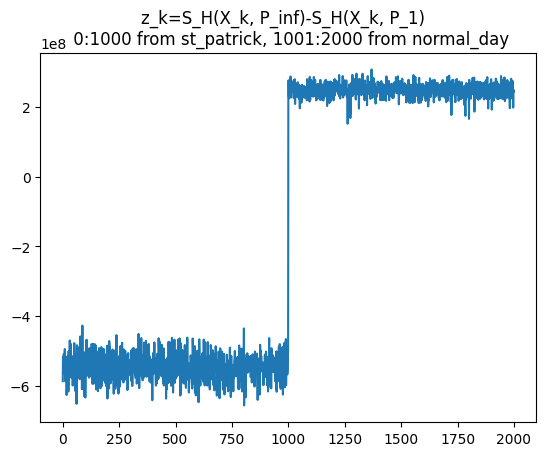

In [27]:
sco_list1=[]
sco_list2=[]
tqdm_data = tqdm.notebook.tqdm(short_test_loader)
for x in tqdm_data:
    x = x.to(device)
    sco_list1.append(SHscore(score_model1, x, marginal_prob_std_fn))
    sco_list2.append(SHscore(score_model2, x, marginal_prob_std_fn))

# Calculate the difference
z_k = [a - b for a, b in zip(sco_list1, sco_list2)]

plt.plot(z_k)
plt.title("z_k=S_H(X_k, P_inf)-S_H(X_k, P_1)  \n 0:1000 from st_patrick, 1001:2000 from normal_day")
# print(np.mean(z_k[0:1000]), np.mean(z_k[1001:2000]))

Text(0.5, 1.0, ' SCUSUM statistics Z(n) \n 0:1000 from st_patrick, 1001:2000 from normal_day')

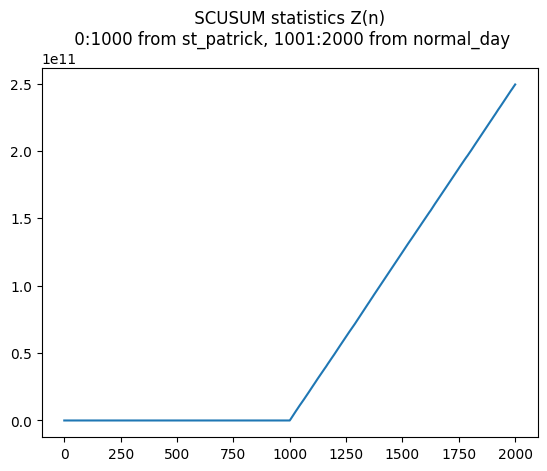

In [30]:
def compute_Z(z_k):
    # Initialize Z with Z(0) = 0
    Z = [0]  # Z will store the values Z(0), Z(1), ..., Z(n)
    
    # Loop over the list of z_k to compute Z(n) iteratively
    for i in range(1, len(z_k) + 1):
        # Compute Z(n) using the recurrence relation
        Z_n = max(Z[i-1] + z_k[i-1], 0)
        Z.append(Z_n)
    
    return Z

# Example usage:
z_k = [a - b for a, b in zip(sco_list1, sco_list2)]
Z_values = compute_Z(z_k)

plt.plot(Z_values)
plt.title(" SCUSUM statistics Z(n) \n 0:1000 from st_patrick, 1001:2000 from normal_day")
